In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB


Let's download the data

In [2]:
data = pd.read_csv('C:\\Users\\valer\\OneDrive\\Desktop\\EpamFinalProject\\train.csv')

In [3]:
data_info = data.info()
data_head = data.head()

data_info, data_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     40000 non-null  object
 1   sentiment  40000 non-null  object
dtypes: object(2)
memory usage: 625.1+ KB


(None,
                                               review sentiment
 0  I caught this little gem totally by accident b...  positive
 1  I can't believe that I let myself into this mo...  negative
 2  *spoiler alert!* it just gets to me the nerve ...  negative
 3  If there's one thing I've learnt from watching...  negative
 4  I remember when this was in theaters, reviews ...  negative)

Our dataset contains 40,000 records and consists of two columns: review and sentiment, positive or negative. There are no missing values, which is a good start. Let's move on to data mining (EDA).

* Analyze the distribution of sentiment: Check if there is an imbalance between positive and negative reviews.
* Analysis of the length of reviews: Evaluate how the length of reviews is distributed and whether there is a difference between positive and negative reviews in terms of length.
* Visualization: We create visualizations to help you better understand the data.

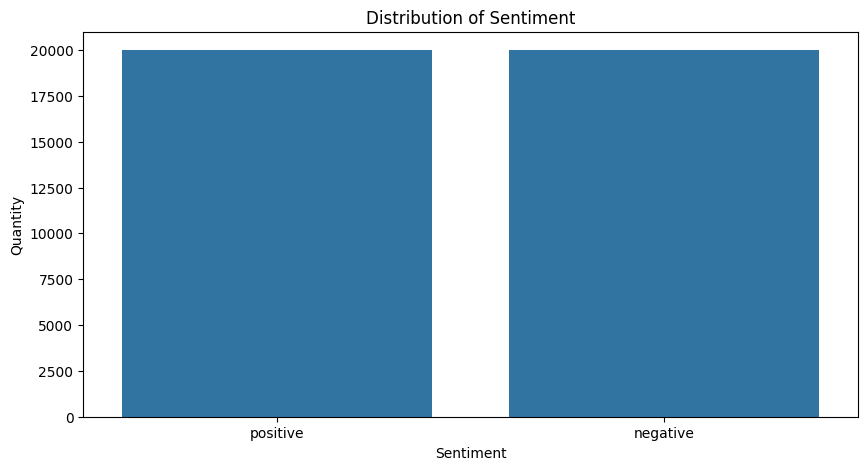

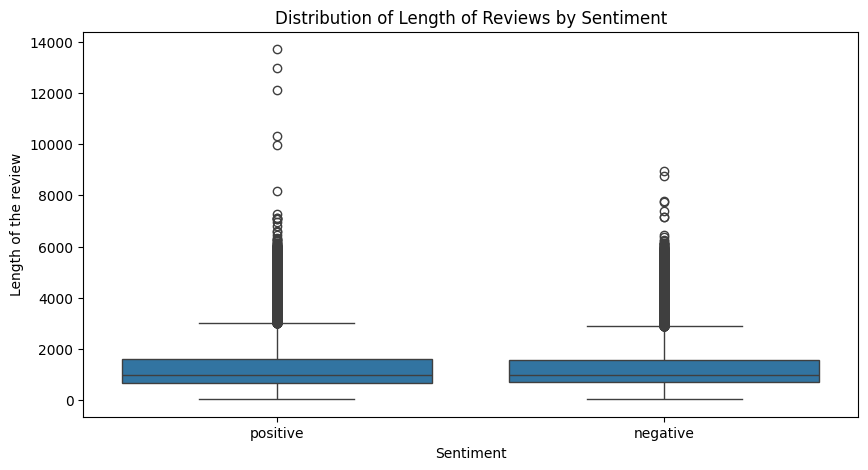

In [5]:
# Sentiment distribution analysis
sentiment_counts = data['sentiment'].value_counts()

# Analyzing the length of reviews
data['review_length'] = data['review'].apply(len)
length_describe = data.groupby('sentiment')['review_length'].describe()

# Visualization of sentiment distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Distribution of Sentiment')
plt.ylabel('Quantity')
plt.xlabel('Sentiment')
plt.show()

# Visualization of the length of reviews
plt.figure(figsize=(10, 5))
sns.boxplot(x='sentiment', y='review_length', data=data)
plt.title('Distribution of Length of Reviews by Sentiment')
plt.ylabel('Length of the review')
plt.xlabel('Sentiment')
plt.show()


* Our dataset has an equal distribution of positive and negative reviews, with 20,000 examples in each category. This means there is no imbalance of classes, which simplifies the modeling process.
* The average length of reviews is about 1300 characters for both categories. However, there is considerable variability in the length of reviews, as seen in the large difference between the 25% and 75% quartiles, as well as the presence of outliers. There are slight differences between positive and negative reviews in terms of length, but they do not seem significant.

A few conclusions:

Balance of classes: The study showed that the dataset has a perfect balance between positive and negative feedback, which is a positive aspect for modeling.

Length of reviews: The variability in the length of reviews can affect the text vectorization process and the possible need to trim or supplement texts for some machine learning models.

Now let's move on to pre-processing the text. To do this, we need to remove all unnecessary links in the text, because they do not carry any useful information, non-alphabetic characters, convert everything to lowercase, tokenize, remove stop words, and since our task is to compare stemming vs lemmatization, we will do both.

In [6]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemma = WordNetLemmatizer()
stemmer = PorterStemmer()

def clean_review(review_text):
    # Delete URL
    review_text = re.sub(r'http\S+', '', review_text)
    # Delete non-alphabetic characters
    review_text = re.sub('[^a-zA-z]', ' ', review_text)
    # Convert to lowercase
    review_text = review_text.lower()
    # Tokenization
    tokens = word_tokenize(review_text)
    # Removing stop words
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatization
    lemma_tokens = [lemma.lemmatize(word=w, pos='v') for w in tokens]
    # Stemming
    stem_tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(lemma_tokens), ' '.join(stem_tokens)

# Using the cleaning function
data['CleanReview_Lemma'], data['CleanReview_Stem'] = zip(*data['review'].apply(clean_review))


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\valer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\valer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\valer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Now we visualize the top 20 most popular words in reviews.

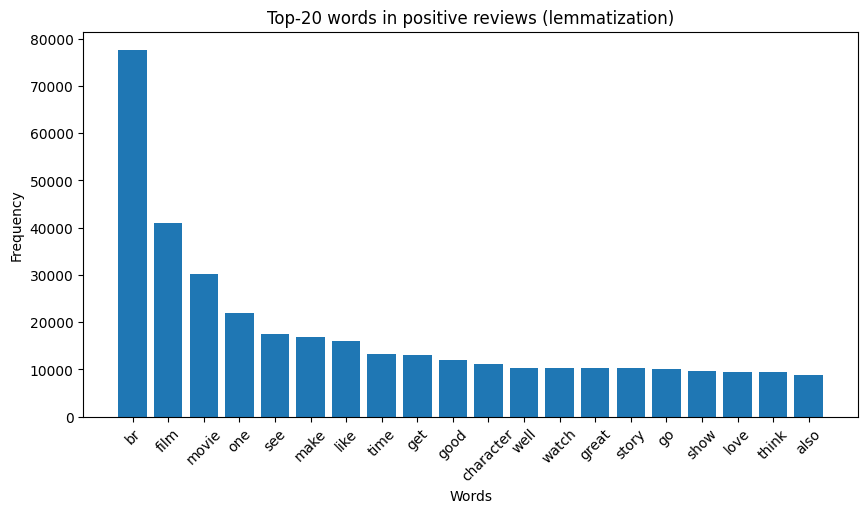

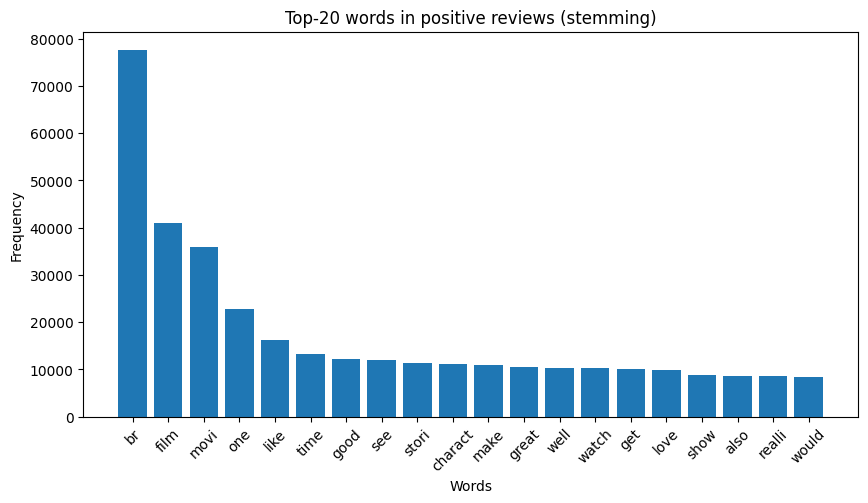

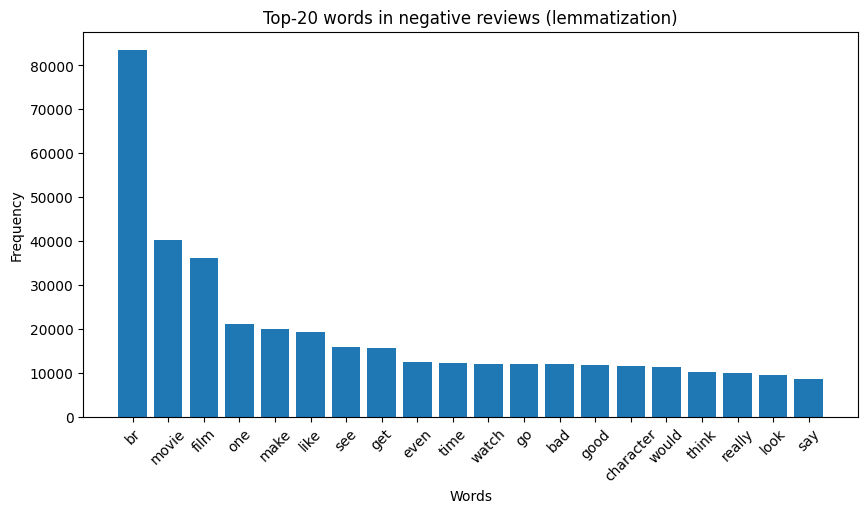

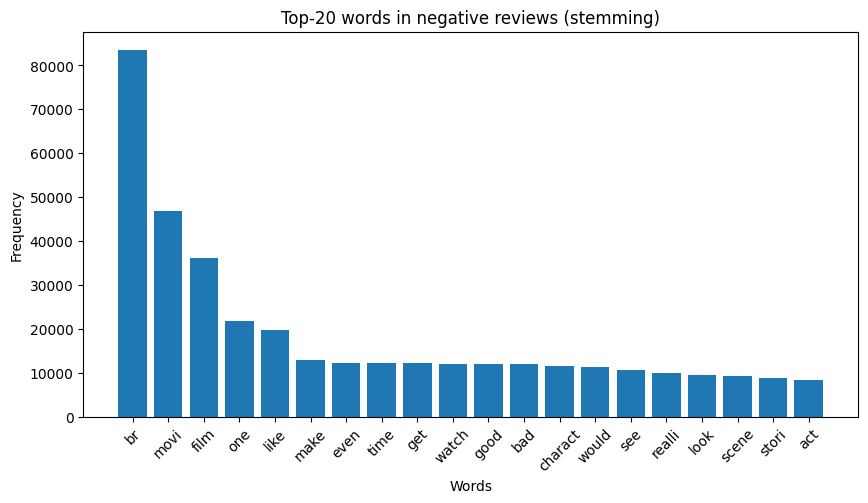

In [7]:
from collections import Counter

def plot_top_words(data, column, sentiment, n=20):
    # Select reviews by sentiment and column
    reviews = data[data['sentiment'] == sentiment][column]
    
    # Merge text and split it into words
    words = ' '.join(reviews).split()
    
    # Counting the frequency of each word
    word_freq = Counter(words)
    
    # Selection of top-N words
    top_words = word_freq.most_common(n)
    
    # Visualization
    top_words, counts = zip(*top_words)
    plt.figure(figsize=(10, 5))
    plt.bar(top_words, counts)
    plt.title(f"Top-{n} words in {'positive' if sentiment == 'positive' else 'negative'} reviews ({'lemmatization' if column == 'CleanReview_Lemma' else 'stemming'})")
    plt.xticks(rotation=45)
    plt.ylabel('Frequency')
    plt.xlabel('Words')
    plt.show()

plot_top_words(data, 'CleanReview_Lemma', 'positive', 20)
plot_top_words(data, 'CleanReview_Stem', 'positive', 20)
plot_top_words(data, 'CleanReview_Lemma', 'negative', 20)
plot_top_words(data, 'CleanReview_Stem', 'negative', 20)

Here we can see that we have too many "br" words, which are redundant from HTML. We have to remove them. We can modify our clean_review function to add the removal of unnecessary tags.

Observation: Here we can clearly observe that there are a words "film", "movie", "one" which are common in all the labels and having highest frequency. So, it will be a good step if we remove the "film", "movie", "one" words from our corpus for a better performance.

In [8]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemma = WordNetLemmatizer()
stemmer = PorterStemmer()

def clean_review(review_text):
    review_text = re.sub(r'http\S+', '', review_text)
    review_text = re.sub('[^a-zA-z]', ' ', review_text)
    review_text = review_text.lower()
    tokens = word_tokenize(review_text)
    tokens = [word for word in tokens if word not in stop_words and word not in ['film', 'movie', 'br', 'one']]
    lemma_tokens = [lemma.lemmatize(word=w, pos='v') for w in tokens]
    stem_tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(lemma_tokens), ' '.join(stem_tokens)

data['CleanReview_Lemma'], data['CleanReview_Stem'] = zip(*data['review'].apply(clean_review))


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\valer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\valer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\valer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Let's visualize again

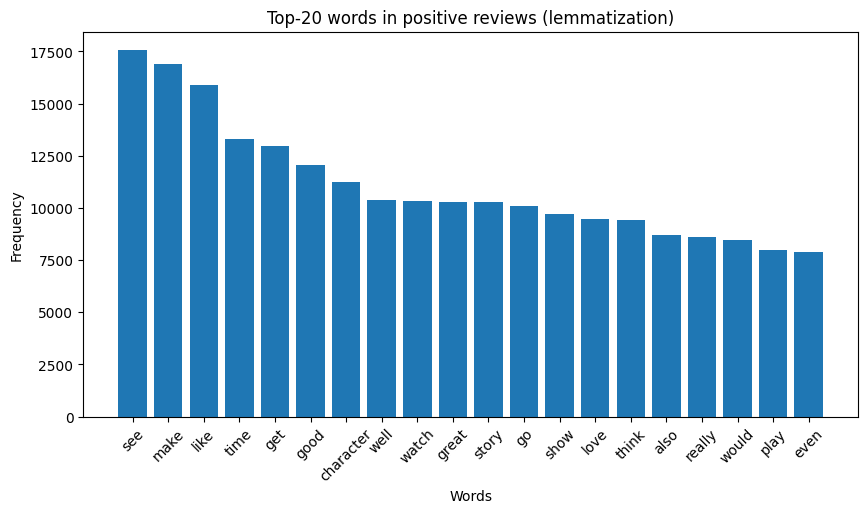

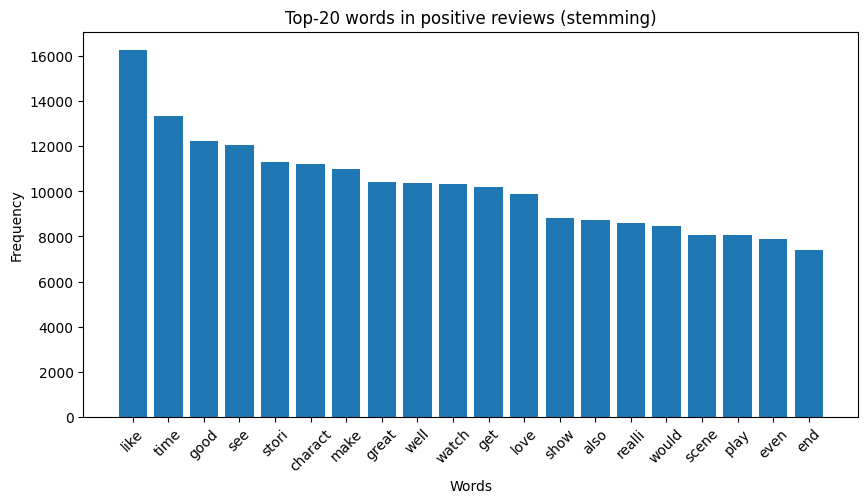

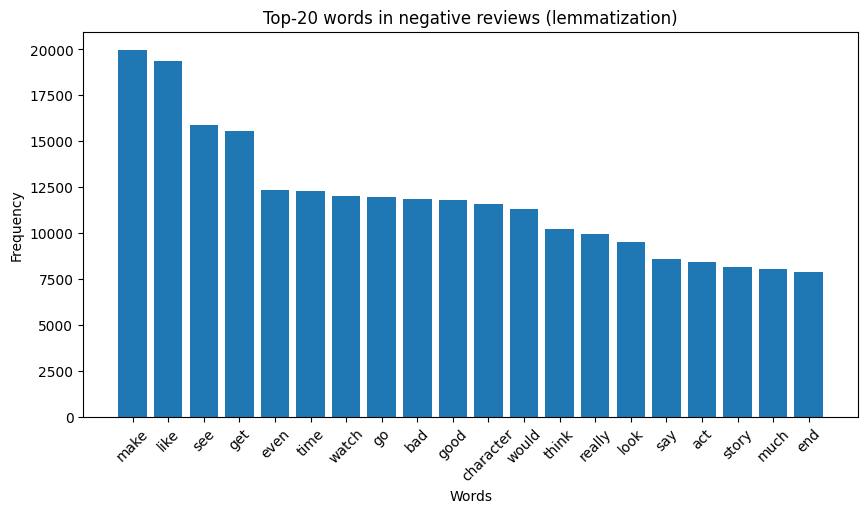

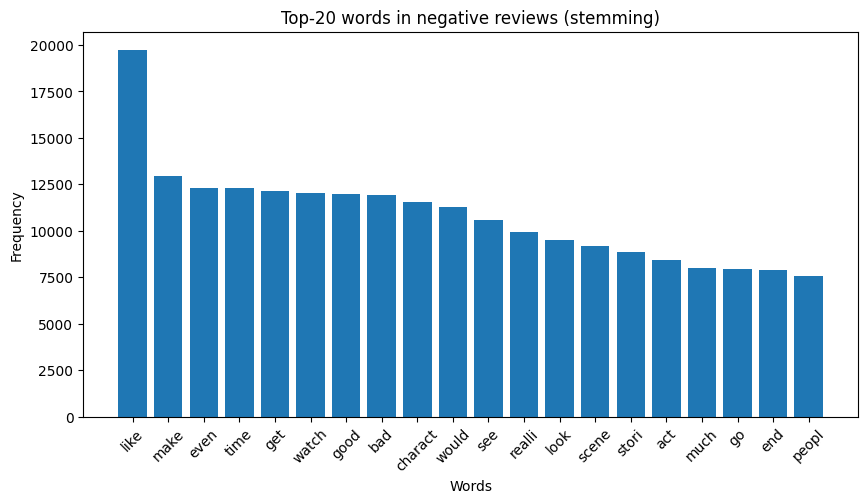

In [9]:
plot_top_words(data, 'CleanReview_Lemma', 'positive', 20)
plot_top_words(data, 'CleanReview_Stem', 'positive', 20)
plot_top_words(data, 'CleanReview_Lemma', 'negative', 20)
plot_top_words(data, 'CleanReview_Stem', 'negative', 20)

Let's move on to vectorization.

Let's compare 2 methods: Count Vectorizer and TF-IDF Vectorization.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Vectorization for lemmatized data
# CountVectorizer
count_vect_lem = CountVectorizer(max_features=5000)
X_counts_lem = count_vect_lem.fit_transform(data['CleanReview_Lemma'])

# TF-IDF
tfidf_vect_lem = TfidfVectorizer(max_features=5000)
X_tfidf_lem = tfidf_vect_lem.fit_transform(data['CleanReview_Lemma'])


# Vectorization for stemmed data
# CountVectorizer
count_vect_stem = CountVectorizer(max_features=5000)
X_counts_stem = count_vect_stem.fit_transform(data['CleanReview_Stem'])

# TF-IDF
tfidf_vect_stem = TfidfVectorizer(max_features=5000)
X_tfidf_stem = tfidf_vect_stem.fit_transform(data['CleanReview_Stem'])


For comparison, let's create a Logistic regression model with all the options and compare their accuracy.

In [11]:
# Function to evaluate model
def evaluate_model(X, y, model, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

# Convert sentiment to numeric values
data['sentiment_code'] = data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
y = data['sentiment_code']

# Models using lemmatization
accuracy_count_lemma = evaluate_model(X_counts_lem, y, LogisticRegression(max_iter=1000))
accuracy_tfidf_lemma = evaluate_model(X_tfidf_lem, y, LogisticRegression(max_iter=1000))

# Models using stemming
accuracy_count_stem = evaluate_model(X_counts_stem, y, LogisticRegression(max_iter=1000))
accuracy_tfidf_stem = evaluate_model(X_tfidf_stem, y, LogisticRegression(max_iter=1000))

# Displaying the results
print(f'Accuracy (CountVectorizer + Lemma): {accuracy_count_lemma}')
print(f'Accuracy (TF-IDF + Lemma): {accuracy_tfidf_lemma}')
print(f'Accuracy (CountVectorizer + Stem): {accuracy_count_stem}')
print(f'Accuracy (TF-IDF + Stem): {accuracy_tfidf_stem}')


Accuracy (CountVectorizer + Lemma): 0.861
Accuracy (TF-IDF + Lemma): 0.884875
Accuracy (CountVectorizer + Stem): 0.865125
Accuracy (TF-IDF + Stem): 0.88225


Since we have very similar metrics for all models, we modify our model evaluation function to determine more metrics

In [12]:

def evaluate_model(X, y, model, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    return accuracy, recall, precision, f1

results = []

metrics_lemma = evaluate_model(X_counts_lem, y, LogisticRegression(max_iter=1000))
results.append(('CountVectorizer + Lemma',) + metrics_lemma)

metrics_lemma_tfidf = evaluate_model(X_tfidf_lem, y, LogisticRegression(max_iter=1000))
results.append(('TF-IDF + Lemma',) + metrics_lemma_tfidf)

metrics_stem = evaluate_model(X_counts_stem, y, LogisticRegression(max_iter=1000))
results.append(('CountVectorizer + Stem',) + metrics_stem)

metrics_stem_tfidf = evaluate_model(X_tfidf_stem, y, LogisticRegression(max_iter=1000))
results.append(('TF-IDF + Stem',) + metrics_stem_tfidf)

df_results = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Recall', 'Precision', 'F1 Score'])
df_results

,Model,Accuracy,Recall,Precision,F1 Score
0,CountVectorizer + Lemma,0.861000,0.861305,0.861734,0.861519
1,TF-IDF + Lemma,0.884875,0.896663,0.876796,0.886618
2,CountVectorizer + Stem,0.865125,0.869024,0.863220,0.866112
3,TF-IDF + Stem,0.882250,0.894422,0.873966,0.884076


* TF-IDF + Stem has the highest Accuracy and F1 score, making it the best model among the four considered. This method also has high completeness and precision scores.
* TF-IDF + Lemma also performs very strongly, especially in terms of completeness, which means that this model is good at identifying positive samples.
* CountVectorizer+Lemma and CountVectorizer+Stem show similar results, but their performance is lower than that of the models using TF-IDF.

Based on these results, TF-IDF seems to be the best choice for text vectorization in this case, regardless of whether stemming or lemmatization is used. Stemming with TF-IDF gives the best overall performance, but the difference between stemming and lemmatization is not significant.

In general, TF-IDF provides better word weights based on their importance in the context of the entire corpus, which may explain its better performance compared to CountVectorizer in this case.

The choice between stemming and lemmatization may depend on the specific needs of our task and how important accuracy is relative to completeness. For tasks where completeness is more important (e.g., when it is important to find as many positive samples as possible), it may be better to choose lemmatization with TF-IDF. For applications where accuracy is more important (e.g., when it is important to minimize the number of false positives), stemming with TF-IDF may be a better choice.

So for further work, let's choose TF-IDF + Stem

Now let's try to find the optimal hyperparameters for our model 

In [18]:
# param_grid = {
#     'C': [0.001, 0.01, 0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# }
param_grid = {
    'C': [2.5, 2.6, 2.7, 2.8, 2.9, 3, 3.1, 3.2, 3.3, 3.4, 3.5]
}

log_reg = LogisticRegression(max_iter=1000)

grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_tfidf_stem, y)

print("The best parameters:", grid_search.best_params_)
print("The best accuracy:", grid_search.best_score_)


The best parameters: {'C': 2.7}
The best accuracy: 0.8853500000000001


Now let's create a model with the best parameters and evaluate it.

In [19]:
best_model = LogisticRegression(C=2.7, max_iter=1000)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf_stem, y, test_size=0.2, random_state=42)

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")
print("\nClassification report:\n", classification_report(y_test, y_pred))


Accuracy: 0.882625
Recall: 0.8924302788844621
Precision: 0.8760694206795404
F1 Score: 0.8841741704699642

Classification report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      3984
           1       0.88      0.89      0.88      4016

    accuracy                           0.88      8000
   macro avg       0.88      0.88      0.88      8000
weighted avg       0.88      0.88      0.88      8000



Our logistic regression model with hyperparameters C=2.7 using TF-IDF for vectorizing text with stemming, showed good results on various metrics. Here's a closer look at each metric:

* Accuracy: 0.882625

The model correctly classifies about 88.26% of the cases. This is a good result, especially for a balanced classification task.

* Recall: 0.8924

Completeness of more than 89% means that the model effectively detects positive cases. In the context of sentiment analysis, this means that the model is good at identifying positive reviews.

* Precision: 0.8761

The accuracy of almost 88% indicates that among the cases that the model classified as positive, about 88% are actually positive. This is important because misclassifying a negative review as positive can have negative consequences.

* F1 score: 0.8842

The F1 score, which is a harmonic mean between accuracy and completeness, demonstrates that the model evaluates reviews in a balanced way.


The classification report shows that the model has a similar performance for both classes (positive and negative reviews), which indicates that it works in a balanced way.


Conclusions:
* The model demonstrates high accuracy and balanced metrics, which makes it reliable for the sentiment classification task.
* The high completeness means that the model effectively detects positive reviews while maintaining high accuracy.
* Balanced metrics for both classes indicate that the model performs equally well with both positive and negative reviews.

Overall, this model seems to be robust for use in sentiment analysis tasks where it is important to identify both positive and negative reviews in a balanced way.

Now let's try the C-Support Vector Classification model

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_stem, y, test_size=0.2, random_state=42)

svm_model = LinearSVC(random_state=42)

svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")
print("\nClassification report:\n", classification_report(y_test, y_pred))

c:\Users\valer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy: 0.877
Recall: 0.8832171314741036
Precision: 0.8732151649433777
F1 Score: 0.8781876702153999

Classification report:
               precision    recall  f1-score   support

           0       0.88      0.87      0.88      3984
           1       0.87      0.88      0.88      4016

    accuracy                           0.88      8000
   macro avg       0.88      0.88      0.88      8000
weighted avg       0.88      0.88      0.88      8000



We got good results, but we will try to improve them by finding the optimal hyperparameters

In [21]:
svm_model = LinearSVC(random_state=42)

param_grid = {
    'C': [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 10, 100]
}

grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

print("The best parameters:", grid_search.best_params_)
print("The best accuracy:", grid_search.best_score_)

c:\Users\valer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\valer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\valer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\valer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of 

The best parameters: {'C': 0.1}
The best accuracy: 0.8850624999999999


c:\Users\valer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\valer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Now let's create a model with the best parameters and evaluate it.

In [22]:
best_model = LinearSVC(C=0.1, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf_stem, y, test_size=0.2, random_state=42)

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")
print("\nClassification report:\n", classification_report(y_test, y_pred))


c:\Users\valer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy: 0.8825
Recall: 0.896414342629482
Precision: 0.8729388942774006
F1 Score: 0.8845208845208845

Classification report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      3984
           1       0.87      0.90      0.88      4016

    accuracy                           0.88      8000
   macro avg       0.88      0.88      0.88      8000
weighted avg       0.88      0.88      0.88      8000



* Accuracy is 88.25%: This indicates that the model correctly classified about 88% of the cases. For a binary classification task, such as dividing reviews into positive and negative, this is a very good result.
* Recall is 89.64%: High recall shows that the model is very effective at identifying positive reviews. This means that most positive reviews were correctly identified by the model.
* Precision is 87.29%: This means that when the model predicts a review as positive, it is correct 88% of the time. This metric is important to ensure that negative reviews are not falsely classified as positive.
* F1 Score - 88.45%: The F1 Score is a harmonic mean between accuracy and completeness that provides a balanced assessment of these two metrics. A high F1 Score indicates that the model has a high and balanced performance.

Overall, the model seems to be very reliable and effective for classifying movie reviews. The high metric values suggest that the model generalizes the data well and can be reliably used for real-world scenarios of review classification.

Let's also try Random Forest

In [23]:
rf_model = RandomForestClassifier(random_state=42)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print(f"\nAccuracy: {accuracy_rf}")
print(f"Recall: {recall_rf}")
print(f"Precision: {precision_rf}")
print(f"F1 Score: {f1_rf}")



Accuracy: 0.844
Recall: 0.8329183266932271
Precision: 0.8528811830698623
F1 Score: 0.8427815570672713


Let's find the hyperparameters

In [24]:
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
{'max_depth': 30, 'n_estimators': 300}


In [25]:
best_rf_model = RandomForestClassifier(max_depth=30, n_estimators=300, random_state=42)

best_rf_model.fit(X_train, y_train)

y_pred_rf = best_rf_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print(f"Accuracy: {accuracy_rf}")
print(f"Recall: {recall_rf}")
print(f"Precision: {precision_rf}")
print(f"F1 Score: {f1_rf}")
print("\nClassification report:\n", classification_report(y_test, y_pred_rf))

Accuracy: 0.84525
Recall: 0.8625498007968128
Precision: 0.8346987951807229
F1 Score: 0.8483957874112172

Classification report:
               precision    recall  f1-score   support

           0       0.86      0.83      0.84      3984
           1       0.83      0.86      0.85      4016

    accuracy                           0.85      8000
   macro avg       0.85      0.85      0.85      8000
weighted avg       0.85      0.85      0.85      8000



In general, although the RandomForestClassifier model shows good results, it does not appear to be optimal for our task compared to the other models we have considered.

Let's also try Naive Bayes

In [26]:
nb_model = MultinomialNB()

nb_model.fit(X_train, y_train)

y_pred_nb = nb_model.predict(X_test)

accuracy_nb = accuracy_score(y_test, y_pred_nb)
recall_nb = recall_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb)
f1_nb = f1_score(y_test, y_pred_nb)

print(f"Accuracy: {accuracy_rf}")
print(f"Recall: {recall_rf}")
print(f"Precision: {precision_rf}")
print(f"F1 Score: {f1_rf}")
print("\nClassification report:\n", classification_report(y_test, y_pred_nb))


Accuracy: 0.84525
Recall: 0.8625498007968128
Precision: 0.8346987951807229
F1 Score: 0.8483957874112172

Classification report:
               precision    recall  f1-score   support

           0       0.85      0.84      0.85      3984
           1       0.85      0.85      0.85      4016

    accuracy                           0.85      8000
   macro avg       0.85      0.85      0.85      8000
weighted avg       0.85      0.85      0.85      8000



Let's find the best hyperparameters

In [27]:
nb_model = MultinomialNB()

param_grid = {'alpha': [0.001, 0.01, 0.1, 0.5, 1, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 2.1, 2.2, 2.3, 2.4, 2.5, 5, 10, 20, 50, 100]}

grid_search = GridSearchCV(nb_model, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

print("The best hyperparameters:", grid_search.best_params_)

The best hyperparameters: {'alpha': 10}


In [28]:
nb_best_model = MultinomialNB(alpha=10)

nb_best_model.fit(X_train, y_train)

y_pred_nb = nb_best_model.predict(X_test)

accuracy_nb = accuracy_score(y_test, y_pred_nb)
recall_nb = recall_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb)
f1_nb = f1_score(y_test, y_pred_nb)

print(f"Accuracy: {accuracy_rf}")
print(f"Recall: {recall_rf}")
print(f"Precision: {precision_rf}")
print(f"F1 Score: {f1_rf}")
print("\nClassification report:\n", classification_report(y_test, y_pred_nb))


Accuracy: 0.84525
Recall: 0.8625498007968128
Precision: 0.8346987951807229
F1 Score: 0.8483957874112172

Classification report:
               precision    recall  f1-score   support

           0       0.85      0.86      0.85      3984
           1       0.86      0.85      0.85      4016

    accuracy                           0.85      8000
   macro avg       0.85      0.85      0.85      8000
weighted avg       0.85      0.85      0.85      8000



The Naive Bayes model turns out to be less effective for our task of classifying movie reviews compared to other models we have considered. Hence, this makes it a lower priority for use in our project.

So we need to choose the best model that suits our task. The most extreme models were LinearSVC and Logistic Regression. So lets compare them.

* LinearSVC:

Accuracy: 0.8825

Recall: 0.896414342629482

Precision: 0.8729388942774006

F1 Score: 0.8845208845208845

Classification report:

               precision    recall  f1-score   support

           0       0.89      0.87      0.88      3984

           1       0.87      0.90      0.88      4016

    accuracy                           0.88      8000

    macro avg       0.88      0.88      0.88      8000
   
    weighted avg       0.88      0.88      0.88      8000
    
* Logistic Regression:

Accuracy: 0.882625

Recall: 0.8924302788844621

Precision: 0.8760694206795404

F1 Score: 0.8841741704699642

Classification report:

               precision    recall  f1-score   support

           0       0.89      0.87      0.88      3984

           1       0.88      0.89      0.88      4016

    accuracy                           0.88      8000

    macro avg       0.88      0.88      0.88      8000

    weighted avg       0.88      0.88      0.88      8000

* Accuracy: LinearSVC has an accuracy of 0.8825, and Logistic Regression has an accuracy of 0.882625. The difference is minimal.

* Recall: LinearSVC has a recall of 0.8964 and Logistic Regression has a recall of 0.8924. Again, the difference is insignificant.

* Accuracy: LinearSVC has an accuracy of 0.8729 and Logistic Regression has an accuracy of 0.8761. The accuracy values are close.

* F1 score: LinearSVC has an F1 score of 0.8845 and Logistic Regression has an F1 score of 0.8842. The F1 scores are very similar.

Given the small differences and the overall similarity in the results, it remains difficult to make a definitive statement that one model is better than the other based on these results alone. Nevertheless, I would choose LinearSVC because it has a slightly better recall and F1